In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Lambda
from keras import optimizers
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import seaborn as sns


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
import os

#mount your Google drive into this notebook
drive.mount('/content/gdrive')
#find the path to your Google drive root
os.getcwd()+"/gdrive/My Drive"
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Machine Learning/Competitive Project')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#train data
df = pd.read_csv("train_final.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income>50K
0,53,Self-emp-not-inc,93449,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,1
1,33,Self-emp-not-inc,123424,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,47,Private,144844,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,40,Private,114580,HS-grad,9,Divorced,Craft-repair,Other-relative,White,Female,0,0,40,Vietnam,0
4,39,Private,115618,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States,0


In [0]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income>50K         int64
dtype: object

In [0]:
#new test data
new_df = pd.read_csv("test_final.csv")
new_df = new_df.loc[:, new_df.columns != 'ID'] # remove ID column as it is not an attribute 
new_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,33,Self-emp-not-inc,222162,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
1,68,?,29240,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,0,12,United-States
2,34,Private,103596,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
3,57,Private,103403,5th-6th,3,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
4,48,Private,152915,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States


In [0]:
def missing(dataset):
  col_names = dataset.columns
  num_data = dataset.shape[0]
  miss_attr = []
  for c in col_names:
      num_non = dataset[c].isin(["?"]).sum()
      if num_non > 0:
          print (c) # collumn name
          print (num_non) # number is missing data in that collumn
          print ("{0:.2f}%".format(float(num_non) / num_data * 100))
          print ("\n")
          miss_attr.append(c)
  return miss_attr  
  
def replace_missing(dataset):
  missing_attr = missing(dataset)
  #replace missing value with most frequent/count value
  for i in missing_attr:
    dataset[i] = dataset[i].replace(['?'], dataset[i].value_counts().index[0]) 

In [0]:
replace_missing(df)
replace_missing(new_df)

workclass
1437
5.75%


occupation
1442
5.77%


native.country
427
1.71%


workclass
1362
5.71%


occupation
1367
5.73%


native.country
430
1.80%




In [0]:
# X_display = df.drop('income>50K',axis=1)
# y_display = df['income>50K']
def cat_to_num(data):
  int_columns = data.select_dtypes(['int64']).columns
  data[int_columns] = data[int_columns].astype('float32') # convert integer to float

  cat_columns = data.select_dtypes(['object']).columns
  data[cat_columns] = data[cat_columns].astype('category') #covert categorical to numerical
  data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
  return data


df = cat_to_num(df)  
X = df.drop('income>50K',axis=1)
y = df['income>50K']

In [0]:
X.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,53.0,5,93449.0,14,15.0,2,9,0,1,1,0.0,0.0,40.0,17
1,33.0,5,123424.0,9,13.0,2,3,0,4,1,0.0,0.0,40.0,37
2,47.0,3,144844.0,11,9.0,2,2,0,4,1,0.0,0.0,40.0,37
3,40.0,3,114580.0,11,9.0,0,2,2,4,0,0.0,0.0,40.0,38
4,39.0,3,115618.0,11,9.0,2,13,0,4,1,0.0,0.0,50.0,37


In [0]:
# normalize data (this is important for model convergence)
def nor(X_):
  dtypes = list(zip(X_.dtypes.index, map(str, X_.dtypes)))
  for k,dtype in dtypes:
      if dtype == "float32":
          X_[k] -= X_[k].mean()
          X_[k] /= X_[k].std()
  return X_        

X= nor(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [0]:
X_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
3253,-0.925221,3,-0.520043,1,-1.193166,2,13,0,4,1,-0.147002,-0.217497,-0.445283,37
18789,1.407242,3,-0.095912,11,-0.416951,6,2,4,4,1,-0.147002,-0.217497,-0.042501,37
4466,1.334352,4,-1.431293,14,1.911693,2,9,0,4,1,-0.147002,-0.217497,-0.364726,37
19269,-0.706553,3,0.471473,15,-0.028844,4,11,1,2,1,-0.147002,-0.217497,1.165842,26
6527,0.095231,3,-0.312117,11,-0.416951,5,6,4,4,1,-0.147002,-0.217497,-0.042501,37


In [0]:
new_df = cat_to_num(new_df)
new_X= nor(new_df)

In [0]:
new_X.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,-0.408084,5,0.299715,11,-0.421831,2,2,0,4,1,-0.142459,-0.21674,-0.025232,38
1,2.146424,3,-1.531007,11,-0.421831,6,9,1,4,0,-0.142459,-0.21674,-2.289253,38
2,-0.335098,3,-0.825410,11,-0.421831,2,5,0,4,1,-0.142459,-0.21674,-0.025232,38
3,1.343579,3,-0.827242,4,-2.760922,2,13,0,4,1,-0.142459,-0.21674,-0.025232,38
4,0.686705,3,-0.357400,15,-0.031983,4,0,1,4,0,-0.142459,-0.21674,-0.025232,38


### **Neural Network Model**

In [0]:
def create_model(lr):
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape= (X_train.shape[1],))) # use drop out to reduce overfitting
    #model.add(Dense(10, input_dim=X_train.shape[1], activation='relu',kernel_initializer= 'he_normal'))
    model.add(Dense(10, activation='relu',kernel_initializer= 'he_normal'))
    model.add(Dense(10, activation='relu',kernel_initializer= 'he_normal'))
    # model.add(Dense(10, activation='relu',kernel_initializer= 'he_normal'))
    model.add(Dense(1))
    #optimizer
    opt = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    # Compile model
    model.compile(optimizer =opt, loss = 'mean_squared_error', metrics=['accuracy'])
    return model

Learning Rate = 0.01


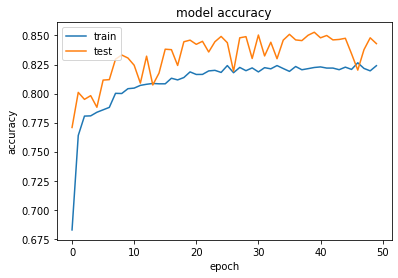

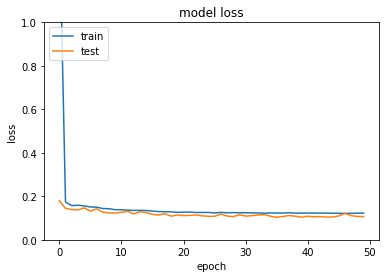

Learning Rate = 0.001


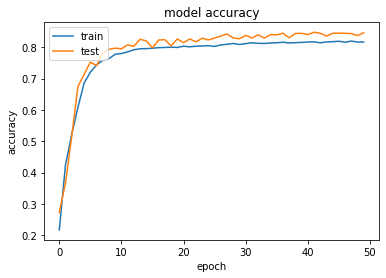

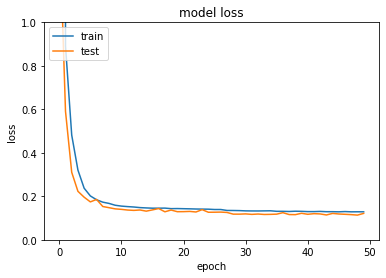

Learning Rate = 0.0001


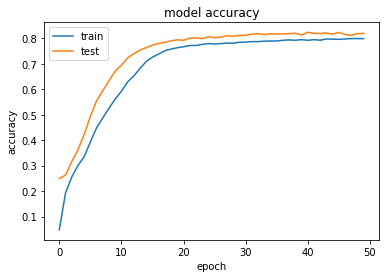

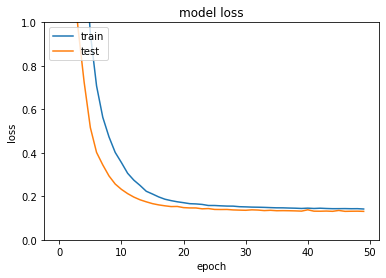

Learning Rate = 1e-05


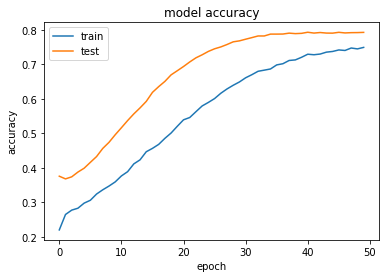

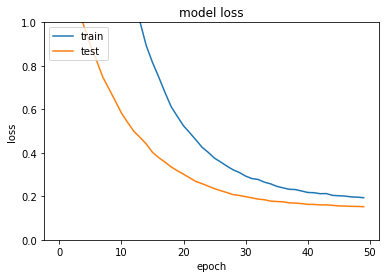

In [0]:
learning_rates = [1E-2, 1E-3, 1E-4, 1E-5]
for i in learning_rates:
  print('Learning Rate = %s'%(i))
  # summarize history for accuracy
  model = create_model(i)
  history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=32, verbose=0)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  #plt.text(25,0.5, 'Learning Rate = %s'%(i))
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.ylim(ymin=0, ymax=1)
  plt.legend(['train', 'test'], loc='upper left')
  #plt.text(25,0.5, 'Learning Rate = %s'%(i))
  plt.show()

In [0]:
#pick optimal learning rate
lr= 0.001
model = create_model(lr)
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=50, batch_size=32, verbose=0)

In [0]:
y_pred = model.predict_classes(new_X)

In [0]:
print(y_pred[8])
pd.DataFrame(y_pred).to_csv("nn_0425.csv")

[0]
